In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
from IPython.display import clear_output
import imageio

# Evo-Lisa

The goal of this project is to recreate the Mona Lisa painting using circles of different sizes, radiuses and colors (including alpha channel).

---

I'm using the genetic algorithm. I'm starting with a randomly initialized population and then in every generation, I'm scoring the current population, selecting the best individuals for the reproduction, adding random mutations, and creating a new population, based on the best individuals from parents and children (only a fraction of parents populations can be chosen to force some changes).

---

The gene contains 7 float numbers in the [0,1] range for each circle.

The single circle is described as x, y, radius, r, g, b, alpha. When converting genotype to phenotype those values are multiplied by maximum values of each feature, that is width, height, min(height, width), 255, 255, 255, 1.

Conversion from genotype to phenotype is done using OpenCV. I'm adding the next circles on the blank image. This approach is very slow, so it's the main bottleneck of the whole algorithm.

For scoring the population I'm using a simple MSE fitness score.

I'm using the roulette wheel and one-point crossover as a selection and crossover algorithms.

The mutation goes as follow:

For each individual and each circle, there is a small chance to mutate. There're 3 options for the mutation: a small change in a random feature, rerolling one feature, or rerolling the whole circle (all of 7 features)

Besides that, for each individual, there's a small chance to mutate the order of circles. If it happens, we're choosing a subsequence of circles to be reversed.

---

There are two methods to speed-up the computations and improve the results:

Instead of using all of the circles during the whole evolution process, I'm starting with one circle, and I'm adding a new one after a few hundreds of iterations. After adding around 25 circles I'm trying to stabilize the algorithm by doing a few thousand iterations with the same number of circles.

After such a process I have a stable background that can be used as a base for the next part of the algorithm. Thanks to that during the next part instead of drawing a hundred circles (for evaluating each individual in each generation), I have to draw only from 1 to 25 circles, which is obviously faster. The downside of this approach is that after finishing the part I can't change the background anymore.

## Final results

This is a result of 50+ hours of a local training and 25 hours of WCSS training (and 100+ hours of unsuccessful trainings). 

The MSE score after 50 hours of evolution (120k generations, 140 circles) was 0.9966, and the next 25 hours of evolution using WCSS computational power gives the score equal to 0.9970 (180k generations, and 190 circles in total), so to gain is really small, and some tweaks in the approach are needed to improve the final result.

In [2]:
def genotype_to_phenotype(genotype, size, image=None):
    if image is None:
        image = np.zeros(size)
    else:
        image = 1-image.copy()
        image *= 255.0
    
    height, width, depth = size
    GENS_MAX_VALS = np.array([width, height, min(height, width), 255, 255, 255, 1])
    for gene in genotype:
        new_image = image.copy()
        circle = GENS_MAX_VALS * gene
        cv2.circle(
            new_image,
            center=tuple(map(int, circle[0:2])),
            radius=int(circle[2]),
            color=list(map(int, circle[3:-1])),
            thickness=-1,
        )
        image = cv2.addWeighted(new_image, circle[-1], image, 1 - circle[-1], 0)
    
    return 1.0-image/255.0

In [3]:
mona2_256 = np.array(imageio.imread('mona2_256.png'))[:,:,:3]/255.0
final_genotype = np.load(f'final_genotype.npy', allow_pickle=True)
final_genotype_history = np.load(f'final_genotype_history.npy', allow_pickle=True)

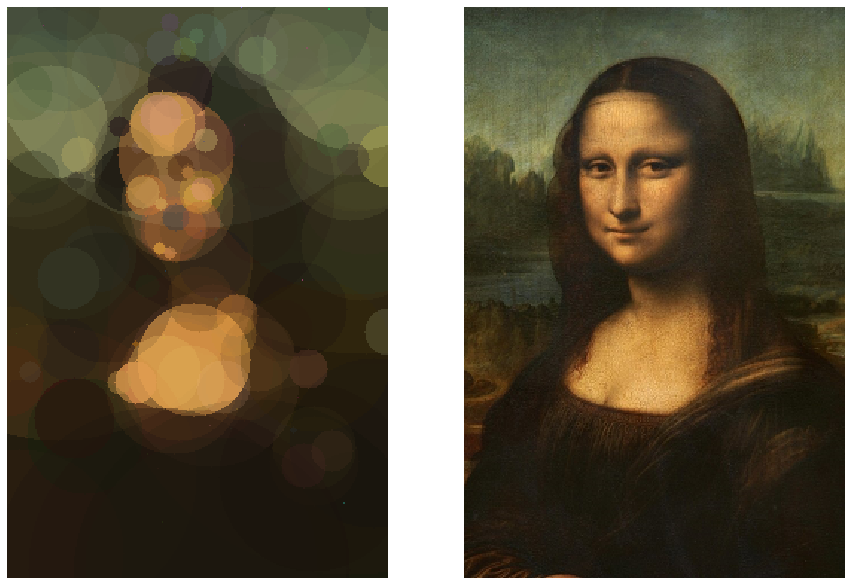

In [4]:
final_mona = genotype_to_phenotype(final_genotype, (384, 256, 3))
f,axs = plt.subplots(1,2,figsize=(15,30))
axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(final_mona)
axs[1].imshow(mona2_256)
plt.show()

In [5]:
lens = ([1000]*24+[6000])*3+[250]*24+[1500]+[500]*39+[3000]+[1000]*24+[6000]+[1000]*24+[6001]
circles_history_ = [[i]*lens[i-1] for i in range(1,len(lens)+1)]
circles_history = []
for e in circles_history_:
    circles_history = circles_history + e
circles_history = np.array(circles_history)

In [6]:
def plot_best_phenotype(
    genotypes_history, 
    fitness_history=None, 
    image_size=(384, 256, 3), 
    show_every=100, 
    background=None, 
    org=None,
    circles_history=None,
):
    
    if fitness_history is None and org is not None:
        MAX_ERROR = np.square((1 - (org >= 0.5)) * 1.0 - org).mean(axis=None)
    
    plt.axis("off")
    for i in range(len(genotypes_history)):
        if i%show_every:
            continue
        phenotype = genotype_to_phenotype(genotypes_history[i], image_size, background)
        if fitness_history is None and org is not None:
            fitness = MSE_fintess(np.array([phenotype]), MAX_ERROR, org)[0]
        else:
            fitness = fitness_history[i][2]
        if org is not None:
            phenotype = np.hstack((phenotype,org))
        if circles_history is not None:
            circles = f', number of circles: {circles_history[i]}'
        else:
            circles = ''
        plt.imshow(phenotype)
        plt.axis("off")
        plt.title(f'Generation {i}, fitness: {np.round(fitness,5)}%'+circles)
        plt.show()
        clear_output(wait=True)

In [7]:
def MSE_fintess(phenotypes, max_error, image):
    mse = np.square(phenotypes - image).mean(axis=(1,2,3))
    return 1 - mse/max_error

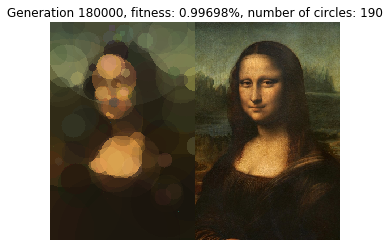

In [8]:
plot_best_phenotype(final_genotype_history, None, (384, 256, 3), 250, org=mona2_256, circles_history=circles_history)

## Sample image

In [2]:
height, width, depth = 256, 256, 3
size = (height, width, depth)

In [3]:
# [x, y, radius, r, g, b, alpha] \in (0,1)^7
gene = np.array([0.5, 0.5, 0.1, 0.5, 0.9, 0.9, 0.75])
gene2 = np.array([0.5, 0.5, 0.15, 0.5, 0.9, 0.9, 0.15])
gene3 = np.array([0.25, 0.25, 0.05, 1.0, 0.0, 0.0, 0.5])
gene4 = np.array([0.75, 0.25, 0.05, 0.0, 1.0, 0.0, 0.5])
gene5 = np.array([0.5, 0.5, 0.5, 0.0, 0.0, 1.0, 0.15])
genotype = np.array([gene, gene2, gene3, gene4, gene5])

## Converting genotype to phenotype

In [4]:
def genotype_to_phenotype(genotype, size, image=None):
    if image is None:
        image = np.zeros(size)
    else:
        image = 1-image.copy()
        image *= 255.0
    
    height, width, depth = size
    GENS_MAX_VALS = np.array([width, height, min(height, width), 255, 255, 255, 1])
    for gene in genotype:
        new_image = image.copy()
        circle = GENS_MAX_VALS * gene
        cv2.circle(
            new_image,
            center=tuple(map(int, circle[0:2])),
            radius=int(circle[2]),
            color=list(map(int, circle[3:-1])),
            thickness=-1,
        )
        image = cv2.addWeighted(new_image, circle[-1], image, 1 - circle[-1], 0)
    
    return 1.0-image/255.0

In [5]:
def display_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

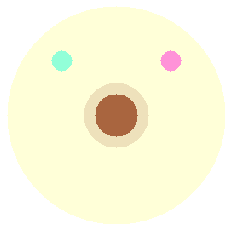

In [6]:
image = genotype_to_phenotype(genotype, size)
display_image(image)

## Fitness function

In [7]:
def MSE_fintess(phenotypes, max_error, image):
    mse = np.square(phenotypes - image).mean(axis=(1,2,3))
    return 1 - mse/max_error

In [8]:
POP_SIZE = 10
NUMBER_OF_CIRCLES = 7
GEN_LEN = 7
population = np.random.rand(POP_SIZE, NUMBER_OF_CIRCLES, GEN_LEN)

In [9]:
phenotypes = np.array([genotype_to_phenotype(genotype, size) for genotype in population])

In [10]:
max_error = np.square((1 - (image >= 0.5)) * 1.0 - image).mean(axis=None)

In [11]:
fitvals = MSE_fintess(phenotypes, max_error, image)

In [12]:
fitvals

array([0.64261155, 0.88144465, 0.78968891, 0.77516384, 0.83354717,
       0.67140004, 0.80971862, 0.88411341, 0.81711225, 0.91263442])

In [13]:
idxs = np.argsort(-fitvals)

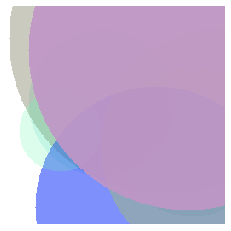

0.9126344179220124

In [14]:
best = idxs[0]
display_image(phenotypes[best])
fitvals[best]

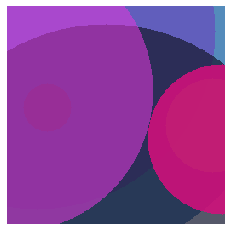

0.6426115521100095

In [15]:
worst = idxs[-1]
display_image(phenotypes[worst])
fitvals[worst]

In [16]:
gene2_ = np.array([0.5, 0.5, 0.4, 0.5, 0.9, 0.9, 0.15])
modified_genotype = np.array([gene, gene2_, gene3, gene4, gene5])

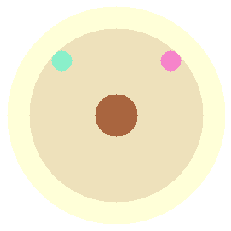

0.9953188368206933

In [17]:
modified_image = genotype_to_phenotype(modified_genotype, size)
display_image(modified_image)
MSE_fintess(np.array([modified_image]), max_error, image)[0]

## Genetic algorithm

### Selection

In [18]:
def roulette_wheel_selection(
    fitvals,
    pop_size,
    number_of_offsprings,
    number_of_parents,
    ):
    
    roulette_scores = fitvals.copy()
    roulette_scores /= roulette_scores.sum()
    parents = np.random.choice(
        pop_size, 
        (number_of_offsprings, 2), 
        True, 
        roulette_scores
    )
    return parents

In [19]:
def pass_selection(
    fitvals,
    pop_size,
    number_of_offsprings,
    number_of_parents,
    ):
    return None

### Crossover

In [20]:
def one_point_crossover(parents_population, parents_indexes, number_of_circles):
    number_of_offsprings, number_of_parents = parents_indexes.shape
    offspring_pop = np.zeros((number_of_offsprings, number_of_circles, 7))
    cross_points = np.random.randint(0, number_of_circles, number_of_offsprings)
    for i in range(number_of_offsprings):
        cp = cross_points[i]
        parent_a, parent_b = parents_indexes[i]
        offspring_pop[i][:cp] = parents_population[parent_a][:cp]
        offspring_pop[i][cp:] = parents_population[parent_b][cp:]
    return offspring_pop

In [21]:
def pass_crossover(parents_population, parents_indexes, number_of_circles):
    offspring_pop = parents_population.copy()
    return offspring_pop

### Mutation

In [22]:
def mutate(population, mutete_prob, gen_len):
    n, m = population.shape[:2]
    m = min(m, gen_len)
    if_mutate = np.random.rand(n, m) < mutete_prob
    for i in range(n):
        for j in range(m):
            if if_mutate[i][j]:
                r = np.random.rand()
                if r < 0.5:
                    k = np.random.randint(0,7)
                    population[i][j][k] += np.random.randn()/20
                    population[i][j][k] = min(1.0, max(0.0, population[i][j][k]))
                elif r < 0.85:
                    k = np.random.randint(0,7)
                    population[i][j][k] = np.random.rand()
                else:
                    population[i][j] = np.random.rand(7)

In [23]:
def muatate_with_shuffle(population, mutete_prob, gen_len):
    n, m = population.shape[:2]
    m = min(m, gen_len)
    if_mutate = np.random.rand(n, m) < mutete_prob
    for i in range(n):
        for j in range(m):
            if if_mutate[i][j]:
                r = np.random.rand()
                if r < 0.5:
                    k = np.random.randint(0,7)
                    population[i][j][k] += np.random.randn()/20
                    population[i][j][k] = min(1.0, max(0.0, population[i][j][k]))
                elif r < 0.85:
                    k = np.random.randint(0,7)
                    population[i][j][k] = np.random.rand()
                else:
                    population[i][j] = np.random.rand(7)
        if np.random.rand() < mutete_prob:
            j1,j2 = np.random.randint(0,m,2)
            j1,j2 = min(j1,j2), max(j1,j2)
            population[i][j1:j2] = population[i][j1:j2][::-1]

### Number of circles 

In [24]:
def default_number_of_circles(t, max_t, max_number_of_circles):
    return max_number_of_circles

In [25]:
def stepping_number_of_circles(t, max_t, max_number_of_circles, step_length, step_hight):
    return min(max_number_of_circles, (max(0,t-1)//step_length)*step_hight + step_hight)

### GA

In [26]:
def GA(
    iterations,
    pop_size,
    number_of_offsprings,
    number_of_circles, 
    image, 
    image_size, 
    mutate_prob = 0.1,
    elitism = 0,
    log_every = 10,
    fitness_function = MSE_fintess, 
    selection = roulette_wheel_selection,
    crossover = one_point_crossover,
    mutation = mutate,
    current_number_of_circles = default_number_of_circles,
    backups = 0,
    elitism_after_adding_circles = False,
    background = None,
    ):
    
    fitness_history = []
    genotypes_history = []
    
    population = np.random.rand(pop_size, number_of_circles, 7)
    
    current_NOC = current_number_of_circles(0, iterations, number_of_circles)
    phenotypes = np.array([genotype_to_phenotype(genotype[:current_NOC], image_size, background)
                           for genotype in population])
    MAX_ERROR = np.square((1 - (image >= 0.5)) * 1.0 - image).mean(axis=None)
    fitvals = MSE_fintess(phenotypes, MAX_ERROR, image)
    idxs = np.argsort(-fitvals)[:pop_size]
    population = population[idxs]
    fitvals = fitvals[idxs]
    fitness_history.append((fitvals.min(), fitvals.mean(), fitvals.max()))
    genotypes_history.append(population[0])
    
    prev_NOC = current_NOC
    
    for t in range(iterations+1):
        
        current_NOC = current_number_of_circles(t, iterations, number_of_circles)
        
        if elitism_after_adding_circles and current_NOC != prev_NOC:
            for i in range(1,pop_size):
                population[i,:prev_NOC,:] = population[0,:prev_NOC,:]
            population[:,prev_NOC:current_NOC,2] = population[:,prev_NOC:current_NOC,2] / np.ceil(4*(current_NOC/number_of_circles))
            #population[:,prev_NOC:current_NOC,2] = population[:,prev_NOC:current_NOC,2] / 5
                
        # selection
        parens = selection(fitvals, pop_size, number_of_offsprings, 2)
        
        # crossover
        children_pop = crossover(population, parens, number_of_circles)
        
        # mutation
        mutation(children_pop, mutate_prob, current_NOC)
        
        # scores
        childern_phenotypes = np.array([genotype_to_phenotype(genotype[:current_NOC], image_size, background)
                                        for genotype in children_pop])
        children_fitvals = MSE_fintess(childern_phenotypes, MAX_ERROR, image)
        
        if elitism and current_NOC != prev_NOC:
            phenotypes = np.array([genotype_to_phenotype(genotype[:current_NOC], image_size, background)
                                   for genotype in population[:elitism]])
            fitvals = MSE_fintess(phenotypes, MAX_ERROR, image)
            
        
        # updating population
        population = np.vstack((population[:elitism], children_pop))
        fitvals = np.hstack((fitvals[:elitism], children_fitvals))
        
        # sorting
        idxs = np.argsort(-fitvals)[:pop_size]
        population = population[idxs]
        fitvals = fitvals[idxs]
        
        # updating history
        fitness_history.append((fitvals.min(), fitvals.mean(), fitvals.max()))
        genotypes_history.append(population[0][:current_NOC])
        
        # logging
        if not t%log_every:
            print(f'Iteration: {t}, best fitness: {fitvals[0]}')
        
        if backups and not t%backups:
            np.save(f'backup-{t}', genotypes_history)
            
        prev_NOC = current_NOC
    
    return genotypes_history, fitness_history

### Plotting functions

In [27]:
def plot_fitness_history(history, ymin=0.98, ymax=1.0):
    T = len(history)
    X = np.arange(T)
    history = np.array(history)
    f, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].plot(X, history[:, 0], label='min')
    axs[0].plot(X, history[:, 1], label='mean')
    axs[0].plot(X, history[:, 2], label='max')
    axs[0].legend()
    axs[1].plot(X, history[:, 0], label='min')
    axs[1].plot(X, history[:, 1], label='mean')
    axs[1].plot(X, history[:, 2], label='max')
    axs[1].legend()
    axs[1].set_ylim(ymin,ymax)
    plt.show()

In [28]:
def plot_best_phenotype(
    genotypes_history, 
    fitness_history=None, 
    image_size=(384, 256, 3), 
    show_every=100, 
    background=None, 
    org=None,
    circles_history=None,
):
    
    if fitness_history is None and org is not None:
        MAX_ERROR = np.square((1 - (org >= 0.5)) * 1.0 - org).mean(axis=None)
    
    plt.axis("off")
    for i in range(len(genotypes_history)):
        if i%show_every:
            continue
        phenotype = genotype_to_phenotype(genotypes_history[i], image_size, background)
        if fitness_history is None and org is not None:
            fitness = MSE_fintess(np.array([phenotype]), MAX_ERROR, org)[0]
        else:
            fitness = fitness_history[i][2]
        if org is not None:
            phenotype = np.hstack((phenotype,org))
        if circles_history is not None:
            circles = f', number of circles: {circles_history[i]}'
        else:
            circles = ''
        plt.imshow(phenotype)
        plt.axis("off")
        plt.title(f'Generation {i}, fitness: {np.round(fitness,5)}%'+circles)
        plt.show()
        clear_output(wait=True)

### Trying to reproduce sample image### 

#### (10+10), 7 circles, 2000 iterations, mutate_pbb=0.1

In [22]:
genotypes_history, fitness_history = GA(2000, 10, 10, 7, image, (256, 256, 3), elitism=2, log_every=100)

Iteration: 0, best fitness: 0.9670156530320659
Iteration: 100, best fitness: 0.9937641411664038
Iteration: 200, best fitness: 0.995811199111332
Iteration: 300, best fitness: 0.9965011935719966
Iteration: 400, best fitness: 0.9966004967589016
Iteration: 500, best fitness: 0.997164596713521
Iteration: 600, best fitness: 0.9972398520038643
Iteration: 700, best fitness: 0.9973017062738867
Iteration: 800, best fitness: 0.9973240726739095
Iteration: 900, best fitness: 0.9973319342460014
Iteration: 1000, best fitness: 0.9973357849190639
Iteration: 1100, best fitness: 0.9973586324507375
Iteration: 1200, best fitness: 0.9975128629916649
Iteration: 1300, best fitness: 0.9975360343482518
Iteration: 1400, best fitness: 0.997566794572698
Iteration: 1500, best fitness: 0.9975853037140621
Iteration: 1600, best fitness: 0.9977646138234106
Iteration: 1700, best fitness: 0.9978421824623971
Iteration: 1800, best fitness: 0.9978762728973658
Iteration: 1900, best fitness: 0.9979787910929928


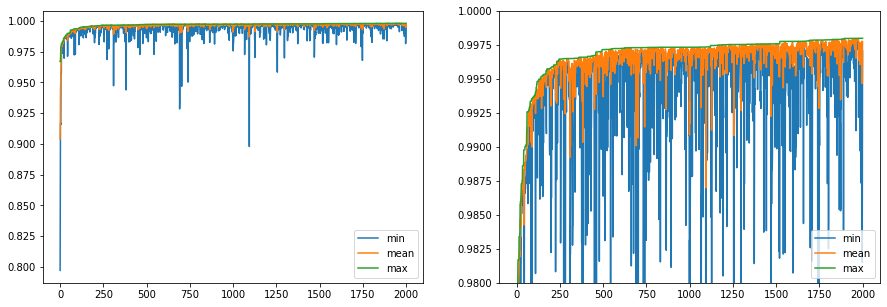

In [24]:
plot_fitness_history(fitness_history)

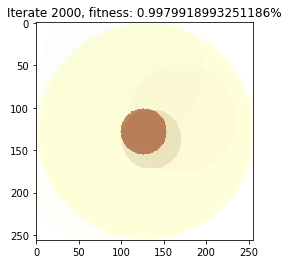

In [36]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 10)

#### (10+10), 10 circles, 5000 iterations, mutate_pbb=0.1

In [38]:
genotypes_history, fitness_history = GA(5000, 10, 10, 10, image, (256, 256, 3), elitism=2, log_every=100)

Iteration: 0, best fitness: 0.8869152101671638
Iteration: 100, best fitness: 0.9927961045592978
Iteration: 200, best fitness: 0.9949770429483956
Iteration: 300, best fitness: 0.9966198351575875
Iteration: 400, best fitness: 0.9968268952835561
Iteration: 500, best fitness: 0.9969175086892594
Iteration: 600, best fitness: 0.9969669430552508
Iteration: 700, best fitness: 0.9969948580661369
Iteration: 800, best fitness: 0.9970947610692151
Iteration: 900, best fitness: 0.9971017629667361
Iteration: 1000, best fitness: 0.9972890632021831
Iteration: 1100, best fitness: 0.9973500654762151
Iteration: 1200, best fitness: 0.9973886338039258
Iteration: 1300, best fitness: 0.9975518395708998
Iteration: 1400, best fitness: 0.9975553311972643
Iteration: 1500, best fitness: 0.9976034778459687
Iteration: 1600, best fitness: 0.9976083039154813
Iteration: 1700, best fitness: 0.9976863723609416
Iteration: 1800, best fitness: 0.9977508133966306
Iteration: 1900, best fitness: 0.997752689974528
Iteration: 20

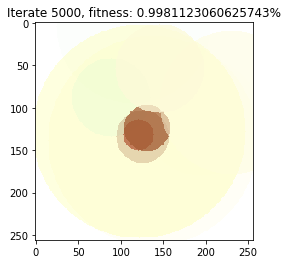

In [39]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 50)

#### (4+4), 7 circles, 5000 iterations, mutate_pbb=0.2

In [41]:
genotypes_history, fitness_history = GA(5000, 4, 4, 7, image, (256, 256, 3), elitism=1, log_every=100, mutate_prob=0.2)

Iteration: 0, best fitness: 0.9655047897533293
Iteration: 100, best fitness: 0.9890612246963444
Iteration: 200, best fitness: 0.9922792776903918
Iteration: 300, best fitness: 0.9927594530834504
Iteration: 400, best fitness: 0.9939501230811468
Iteration: 500, best fitness: 0.9941333170473703
Iteration: 600, best fitness: 0.9944144777113676
Iteration: 700, best fitness: 0.9950551289172316
Iteration: 800, best fitness: 0.9954703160039406
Iteration: 900, best fitness: 0.9958934927897107
Iteration: 1000, best fitness: 0.9965392500494278
Iteration: 1100, best fitness: 0.9966299430877003
Iteration: 1200, best fitness: 0.9970823823176733
Iteration: 1300, best fitness: 0.9971273006057472
Iteration: 1400, best fitness: 0.9971388706705596
Iteration: 1500, best fitness: 0.9971628258608856
Iteration: 1600, best fitness: 0.9972210851876379
Iteration: 1700, best fitness: 0.9973145334159647
Iteration: 1800, best fitness: 0.9974254313957146
Iteration: 1900, best fitness: 0.997496766608335
Iteration: 20

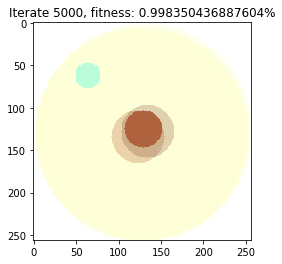

In [43]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 50)

#### (5+5), 7 circles, 10000 iterations, mutate_pbb=0.25, without crossover

In [51]:
genotypes_history, fitness_history = GA(10000, 5, 5, 7, image, (256, 256, 3), 
        elitism=1, log_every=500, mutate_prob=0.25, crossover=pass_crossover)

Iteration: 0, best fitness: 0.9524828195530792
Iteration: 500, best fitness: 0.9930683981841203
Iteration: 1000, best fitness: 0.996505764642072
Iteration: 1500, best fitness: 0.9970307515339419
Iteration: 2000, best fitness: 0.997379367563881
Iteration: 2500, best fitness: 0.997507890815395
Iteration: 3000, best fitness: 0.997618141897785
Iteration: 3500, best fitness: 0.9976798920005129
Iteration: 4000, best fitness: 0.9977925382434023
Iteration: 4500, best fitness: 0.9978057132510143
Iteration: 5000, best fitness: 0.9978340541335277
Iteration: 5500, best fitness: 0.9978431634203677
Iteration: 6000, best fitness: 0.9979078349098048
Iteration: 6500, best fitness: 0.9979767269799042
Iteration: 7000, best fitness: 0.9980006020659457
Iteration: 7500, best fitness: 0.9981370373564494
Iteration: 8000, best fitness: 0.9981831488757676
Iteration: 8500, best fitness: 0.9982646768461729
Iteration: 9000, best fitness: 0.9982879190041855
Iteration: 9500, best fitness: 0.9983232599213888
Iteratio

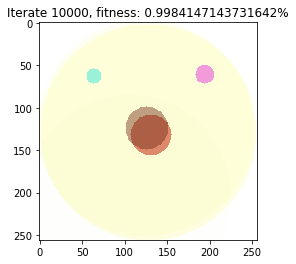

In [52]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 100)

Change in mutate function (higher chance to change whole circle instead of one value)

#### (1+1), 7 circles, 20000 iterations, mutate_prob=1.0, without crossover

In [59]:
genotypes_history, fitness_history = GA(100000, 1, 1, 7, image, (256, 256, 3), 
        elitism=1, log_every=5000, mutate_prob=1.0, crossover=pass_crossover, selection=pass_selection)

Iteration: 0, best fitness: 0.9450402451686899
Iteration: 5000, best fitness: 0.9977735505887773
Iteration: 10000, best fitness: 0.9984400649276978
Iteration: 15000, best fitness: 0.9989046823205575
Iteration: 20000, best fitness: 0.9989261179693683
Iteration: 25000, best fitness: 0.9989578499436879
Iteration: 30000, best fitness: 0.9989719333059771
Iteration: 35000, best fitness: 0.9989724599063055
Iteration: 40000, best fitness: 0.9989871866088902
Iteration: 45000, best fitness: 0.998987812797555
Iteration: 50000, best fitness: 0.9990001774117389
Iteration: 55000, best fitness: 0.9990485682004416
Iteration: 60000, best fitness: 0.9990936243355534
Iteration: 65000, best fitness: 0.9991108663666876
Iteration: 70000, best fitness: 0.9991108663666876
Iteration: 75000, best fitness: 0.9991168417487054
Iteration: 80000, best fitness: 0.9991168417487054
Iteration: 85000, best fitness: 0.9991498635801012
Iteration: 90000, best fitness: 0.999186512219137
Iteration: 95000, best fitness: 0.9992

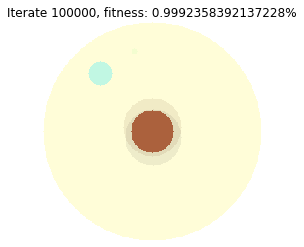

In [60]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 500)

#### (50+50), 7 circles, 10000 iterations, mutate_prob=0.2

In [63]:
genotypes_history, fitness_history = GA(10000, 50, 50, 7, image, (256, 256, 3), elitism=5, log_every=500, mutate_prob=0.2)

Iteration: 0, best fitness: 0.9750461611488176
Iteration: 500, best fitness: 0.9983820304239097
Iteration: 1000, best fitness: 0.9990700438749474
Iteration: 1500, best fitness: 0.9992557287010433
Iteration: 2000, best fitness: 0.9994311272226566
Iteration: 2500, best fitness: 0.9995733004910815
Iteration: 3000, best fitness: 0.9996500879755088
Iteration: 3500, best fitness: 0.9999689103832842
Iteration: 4000, best fitness: 0.9999926508661191
Iteration: 4500, best fitness: 0.9999997122082368
Iteration: 5000, best fitness: 0.9999999047915688
Iteration: 5500, best fitness: 0.9999999052233197
Iteration: 6000, best fitness: 0.9999999477126031
Iteration: 6500, best fitness: 0.9999999541922424
Iteration: 7000, best fitness: 0.9999999569393526
Iteration: 7500, best fitness: 0.9999999617655518
Iteration: 8000, best fitness: 0.9999999618028285
Iteration: 8500, best fitness: 0.9999999618028285
Iteration: 9000, best fitness: 0.9999999783645049
Iteration: 9500, best fitness: 0.9999999789079166
Iter

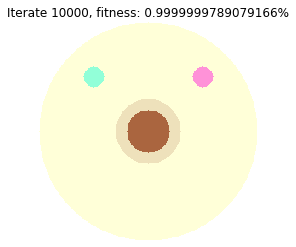

In [64]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 100)

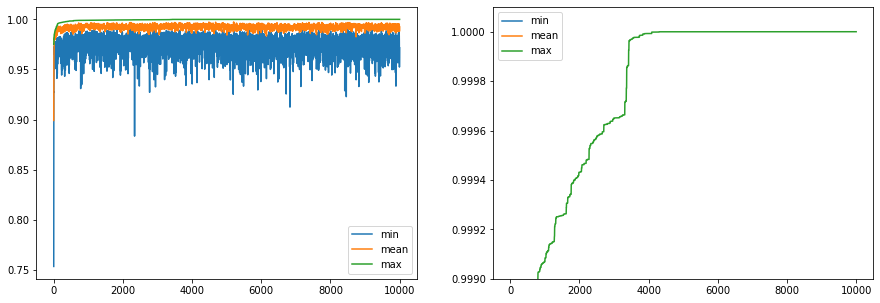

In [76]:
plot_fitness_history(fitness_history, ymin=0.999, ymax=1.0001)

### Using a fraction of circles during the training

In [117]:
genotypes_history, fitness_history = GA(10000, 50, 50, 7, image, (256, 256, 3), elitism=5, log_every=500,
    mutate_prob=0.2, current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,1000,1))

Iteration: 0, best fitness: 0.9852841969390596
Iteration: 500, best fitness: 0.9919146222600767
Iteration: 1000, best fitness: 0.9919642113341816
Iteration: 1500, best fitness: 0.9987192269446622
Iteration: 2000, best fitness: 0.9970228092853444
Iteration: 2500, best fitness: 0.9990000076470947
Iteration: 3000, best fitness: 0.9990843098474403
Iteration: 3500, best fitness: 0.9994265576271424
Iteration: 4000, best fitness: 0.9995405078604027
Iteration: 4500, best fitness: 0.9995559686417831
Iteration: 5000, best fitness: 0.9994200485442004
Iteration: 5500, best fitness: 0.9999991960776915
Iteration: 6000, best fitness: 0.9997828346554332
Iteration: 6500, best fitness: 0.9999997853504103
Iteration: 7000, best fitness: 0.9999998304394008
Iteration: 7500, best fitness: 0.9999998780559579
Iteration: 8000, best fitness: 0.9999999549324461
Iteration: 8500, best fitness: 0.9999999614785888
Iteration: 9000, best fitness: 0.9999999614792995
Iteration: 9500, best fitness: 0.9999999870298221
Iter

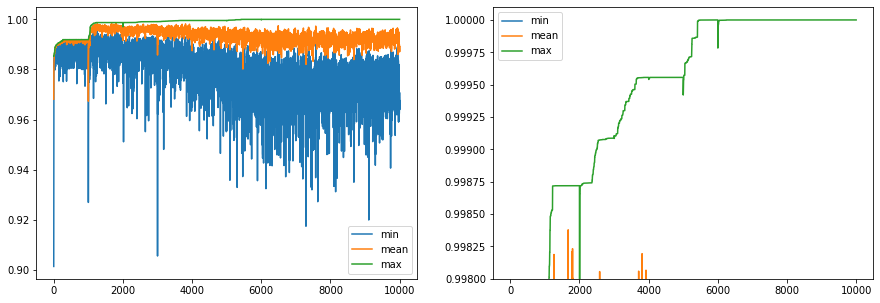

In [128]:
plot_fitness_history(fitness_history, ymin=0.998, ymax=1.0001)

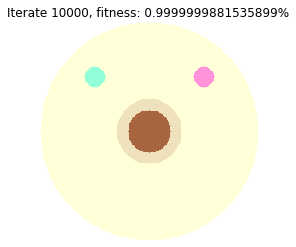

In [123]:
plot_best_phenotype(genotypes_history, fitness_history, (256, 256, 3), 50)

## Mona Lisa reproduction

### Original Mona Lisa

In [29]:
mona_256 = np.array(imageio.imread('256px-Mona_Lisa.png'))[:,:,:3]/255.0
# mona_512 = np.array(imageio.imread('512px-Mona_Lisa.png'))[:,:,:3]/255.0
# mona_1024 = np.array(imageio.imread('1024px-Mona_Lisa.png'))[:,:,:3]/255.0
# mona_2048 = np.array(imageio.imread('2048px-Mona_Lisa.png'))[:,:,:3]/255.0
# mona = np.array(imageio.imread('Mona_Lisa.png'))[:,:,:3]/255.0
mona2_256 = np.array(imageio.imread('mona2_256.png'))[:,:,:3]/255.0

In [9]:
img = cv2.cvtColor(cv2.imread('mona2_256.png',1), cv2.COLOR_BGR2RGB)/255.0

In [155]:
mona_256.shape

(383, 256, 3)

#### A few unsuccessful trainings

In [158]:
genotypes_history, fitness_history = GA(5000, 30, 30, 50, mona_256, (383, 256, 3), elitism=3, log_every=100,
    mutate_prob=0.2, current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,500,10))

Iteration: 0, best fitness: 0.27974903205529666
Iteration: 100, best fitness: 0.5979207505492664
Iteration: 200, best fitness: 0.5993063194061774
Iteration: 300, best fitness: 0.5995188467009238
Iteration: 400, best fitness: 0.5995191545483202
Iteration: 500, best fitness: 0.7579640600261938
Iteration: 600, best fitness: 0.9091712826516509
Iteration: 700, best fitness: 0.9476111744491744
Iteration: 800, best fitness: 0.9564206724384258
Iteration: 900, best fitness: 0.9583575917074737
Iteration: 1000, best fitness: 0.9039953635318387
Iteration: 1100, best fitness: 0.9588892281912278
Iteration: 1200, best fitness: 0.9614316009498526
Iteration: 1300, best fitness: 0.9619852579632312
Iteration: 1400, best fitness: 0.9632487278024957
Iteration: 1500, best fitness: 0.899027851865541
Iteration: 1600, best fitness: 0.961592638448371
Iteration: 1700, best fitness: 0.9625965924455551
Iteration: 1800, best fitness: 0.9634951559914195
Iteration: 1900, best fitness: 0.9641545025967189
Iteration: 20

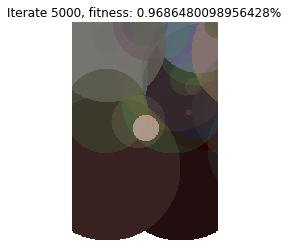

In [164]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 50)

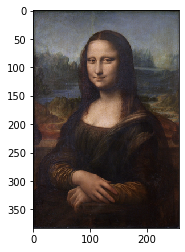

In [162]:
plt.imshow(mona_256)

In [160]:
# np.save('mona-256-1',genotypes_history)

In [35]:
genotypes_history, fitness_history = GA(10000, 30, 30, 256, mona_256, (383, 256, 3), 
    elitism=3, log_every=500, mutate_prob=0.2, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,500,15), backups=1000)

Iteration: 0, best fitness: 0.6841995560249241
Iteration: 500, best fitness: 0.9210366163387744
Iteration: 1000, best fitness: 0.93891587545505
Iteration: 1500, best fitness: 0.9199585953812923
Iteration: 2000, best fitness: 0.9179143930200452
Iteration: 2500, best fitness: 0.8649212182216737
Iteration: 3000, best fitness: 0.9088485055761597
Iteration: 3500, best fitness: 0.8812556302147934
Iteration: 4000, best fitness: 0.9288076856200365
Iteration: 4500, best fitness: 0.9366981904425187
Iteration: 5000, best fitness: 0.8915700041999102
Iteration: 5500, best fitness: 0.9541013941834305
Iteration: 6000, best fitness: 0.94291431269875
Iteration: 6500, best fitness: 0.9130782498857697
Iteration: 7000, best fitness: 0.9077561334171943
Iteration: 7500, best fitness: 0.9553930905820581
Iteration: 8000, best fitness: 0.8840816716285029
Iteration: 8500, best fitness: 0.9616718129673487
Iteration: 9000, best fitness: 0.9689313264890277
Iteration: 9500, best fitness: 0.9711423662938825
Iteratio

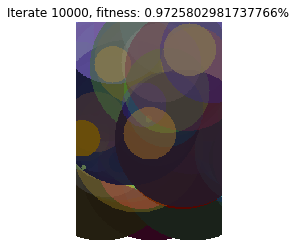

In [36]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 100)

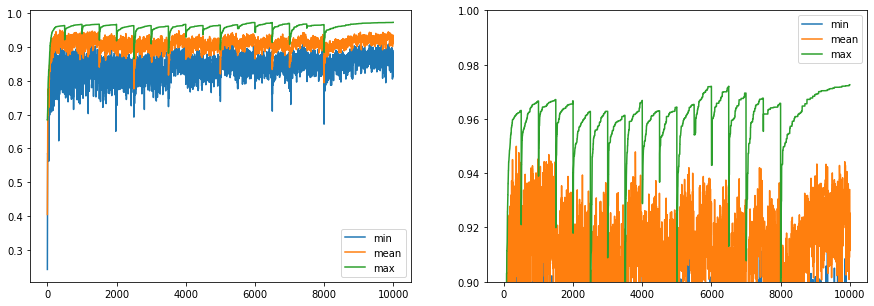

In [39]:
plot_fitness_history(fitness_history, ymin=0.90, ymax=1.0001)

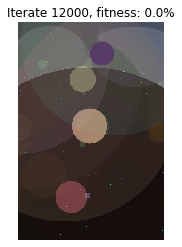

In [46]:
files = f'./Mona-reproduction1/backup-10000.npy'
genotypes_history = np.load(file, allow_pickle=True)
fitness_history = np.zeros((len(genotypes_history),3))
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 100)

-------------------------------

In [69]:
genotypes_history, fitness_history = GA(2000, 30, 30, 15, mona_256, (383, 256, 3), elitism=3, log_every=100,
    mutate_prob=0.2, mutation=muatate_with_shuffle)

Iteration: 0, best fitness: 0.8701386794128069
Iteration: 100, best fitness: 0.9743577486228385
Iteration: 200, best fitness: 0.9776306332479832
Iteration: 300, best fitness: 0.9785335932886415
Iteration: 400, best fitness: 0.9800265109615068
Iteration: 500, best fitness: 0.9804431220256087
Iteration: 600, best fitness: 0.9809344441614604
Iteration: 700, best fitness: 0.9809949913236692
Iteration: 800, best fitness: 0.9820196316556106
Iteration: 900, best fitness: 0.9823099715069146
Iteration: 1000, best fitness: 0.9827596541330147
Iteration: 1100, best fitness: 0.9829892347120793
Iteration: 1200, best fitness: 0.9832586791120412
Iteration: 1300, best fitness: 0.9840957056930186
Iteration: 1400, best fitness: 0.9846723725759866
Iteration: 1500, best fitness: 0.9851230636910797
Iteration: 1600, best fitness: 0.985312842538723
Iteration: 1700, best fitness: 0.9855585621810785
Iteration: 1800, best fitness: 0.9857167993841626
Iteration: 1900, best fitness: 0.9861015531236653
Iteration: 20

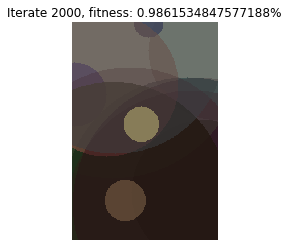

In [71]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 10)

In [83]:
genotypes_history, fitness_history = GA(2000, 30, 30, 15, mona_256, (383, 256, 3), elitism=3, 
    log_every=100, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,100,1))

Iteration: 0, best fitness: 0.6630956589602546
Iteration: 100, best fitness: 0.9577446204248692
Iteration: 200, best fitness: 0.9701965345895517
Iteration: 300, best fitness: 0.975125008303007
Iteration: 400, best fitness: 0.9768963079755892
Iteration: 500, best fitness: 0.978104861865121
Iteration: 600, best fitness: 0.9800490453162343
Iteration: 700, best fitness: 0.9812145774261286
Iteration: 800, best fitness: 0.9824727794876178
Iteration: 900, best fitness: 0.9836095010888445
Iteration: 1000, best fitness: 0.9841430242041949
Iteration: 1100, best fitness: 0.982741122816237
Iteration: 1200, best fitness: 0.9838965003519932
Iteration: 1300, best fitness: 0.9850545767078931
Iteration: 1400, best fitness: 0.9833895117046271
Iteration: 1500, best fitness: 0.9837853585303802
Iteration: 1600, best fitness: 0.9844351374071799
Iteration: 1700, best fitness: 0.9850251037740461
Iteration: 1800, best fitness: 0.9852856786751704
Iteration: 1900, best fitness: 0.9857411306235485
Iteration: 2000

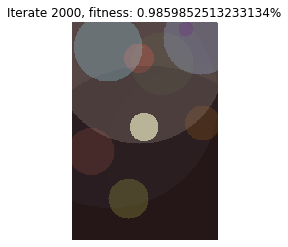

In [84]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 10)

In [30]:
genotypes_history, fitness_history = GA(15000, 30, 30, 256, mona_256, (383, 256, 3), elitism=3, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,50,1),
    elitism_after_adding_circles = True, backups=1000)

Iteration: 0, best fitness: 0.7771527429770023
Iteration: 1000, best fitness: 0.9783659849902062
Iteration: 2000, best fitness: 0.9749257818833567
Iteration: 3000, best fitness: 0.9855482327876329
Iteration: 4000, best fitness: 0.9871341109351311
Iteration: 5000, best fitness: 0.9879822680631692
Iteration: 6000, best fitness: 0.9881814652129474
Iteration: 7000, best fitness: 0.9882494584245314
Iteration: 8000, best fitness: 0.9882598019447068
Iteration: 9000, best fitness: 0.9882361229066741
Iteration: 10000, best fitness: 0.9882186574050712
Iteration: 11000, best fitness: 0.9882049828722441
Iteration: 12000, best fitness: 0.9881831149268635


IndexError: index 256 is out of bounds for axis 0 with size 256

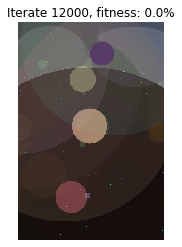

In [45]:
files = f'./Mona-reproduction2/backup-12000.npy'
genotypes_history = np.load(file, allow_pickle=True)
fitness_history = np.zeros((len(genotypes_history),3))
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 100)

In [77]:
genotypes_history, fitness_history = GA(5000, 20, 20, 20, mona_256, (383, 256, 3), elitism=2, 
    log_every=250, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,250,1),
    elitism_after_adding_circles = True, backups=0)

Iteration: 0, best fitness: 0.7496632332291179
Iteration: 250, best fitness: 0.9579342677547069
Iteration: 500, best fitness: 0.9748964968506693
Iteration: 750, best fitness: 0.9769074052033615
Iteration: 1000, best fitness: 0.9778978839779526
Iteration: 1250, best fitness: 0.9787621573925874
Iteration: 1500, best fitness: 0.979911059287186
Iteration: 1750, best fitness: 0.9804810934444578
Iteration: 2000, best fitness: 0.9812430700163078
Iteration: 2250, best fitness: 0.9824324053115389
Iteration: 2500, best fitness: 0.981873912404425
Iteration: 2750, best fitness: 0.9839538532473107
Iteration: 3000, best fitness: 0.9847667616290892
Iteration: 3250, best fitness: 0.9852963566988873
Iteration: 3500, best fitness: 0.9855408551097036
Iteration: 3750, best fitness: 0.9859485997758629
Iteration: 4000, best fitness: 0.9862439719558603
Iteration: 4250, best fitness: 0.98745233426894
Iteration: 4500, best fitness: 0.9876192567319846
Iteration: 4750, best fitness: 0.9880689422408152
Iteration:

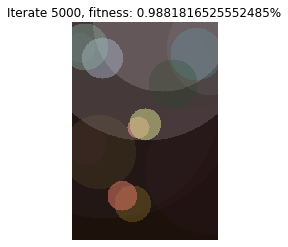

In [78]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 50)

In [79]:
genotypes_history, fitness_history = GA(20000, 25, 25, 75, mona_256, (383, 256, 3), elitism=2, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,250,1),
    elitism_after_adding_circles = True, backups=2500)

Iteration: 0, best fitness: 0.517860473332032
Iteration: 1000, best fitness: 0.9785815123274082
Iteration: 2000, best fitness: 0.9842373366837992
Iteration: 3000, best fitness: 0.9851011595269635
Iteration: 4000, best fitness: 0.9833796401836457
Iteration: 5000, best fitness: 0.9865077012729482
Iteration: 6000, best fitness: 0.9851197804830856
Iteration: 7000, best fitness: 0.9860610623469102
Iteration: 8000, best fitness: 0.9831419179994332
Iteration: 9000, best fitness: 0.9847828441854167
Iteration: 10000, best fitness: 0.984686985844775
Iteration: 11000, best fitness: 0.9845656234842509
Iteration: 12000, best fitness: 0.9836101058588337
Iteration: 13000, best fitness: 0.9861603131205968
Iteration: 14000, best fitness: 0.9793686520849179
Iteration: 15000, best fitness: 0.9822902509074267
Iteration: 16000, best fitness: 0.9780496910697789
Iteration: 17000, best fitness: 0.9763393481186153
Iteration: 18000, best fitness: 0.9725727002947744
Iteration: 19000, best fitness: 0.977372528682

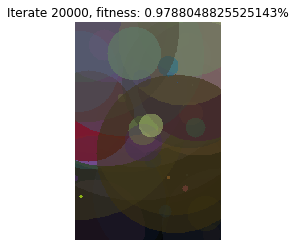

In [80]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 50)

In [30]:
genotypes_history, fitness_history = GA(30000, 40, 40, 25, mona_256, (383, 256, 3), elitism=4, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,1000,1),
    elitism_after_adding_circles = True, backups=5000)

Iteration: 0, best fitness: 0.6792133724787375
Iteration: 1000, best fitness: 0.9579366049093833
Iteration: 2000, best fitness: 0.9750761986082327
Iteration: 3000, best fitness: 0.9764951632588142
Iteration: 4000, best fitness: 0.9799129352255854
Iteration: 5000, best fitness: 0.9819643671968005
Iteration: 6000, best fitness: 0.9845319903088423
Iteration: 7000, best fitness: 0.9849727300500954
Iteration: 8000, best fitness: 0.9858596007861435
Iteration: 9000, best fitness: 0.9866541517623415
Iteration: 10000, best fitness: 0.9880849468661691
Iteration: 11000, best fitness: 0.9887514025396097
Iteration: 12000, best fitness: 0.9890383271887582
Iteration: 13000, best fitness: 0.9889592937030559
Iteration: 14000, best fitness: 0.9895894073895928
Iteration: 15000, best fitness: 0.9899810411283958
Iteration: 16000, best fitness: 0.9900857514768954
Iteration: 17000, best fitness: 0.9904301480468671
Iteration: 18000, best fitness: 0.9906371575375376
Iteration: 19000, best fitness: 0.9900970203

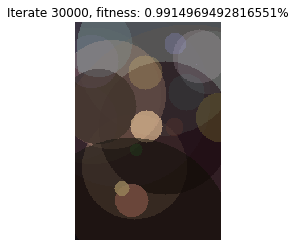

In [31]:
plot_best_phenotype(genotypes_history, fitness_history, (383, 256, 3), 50)

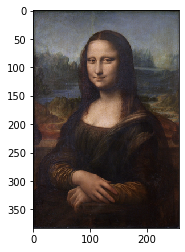

In [37]:
plt.imshow(mona_256)

### Zoomed-in Mona Lisa

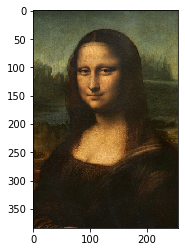

In [41]:
plt.imshow(mona2_256)

#### Part 1: (circles 1-25, generations 0-30000)

In [43]:
genotypes_history, fitness_history = GA(30000, 40, 40, 25, mona2_256, (384, 256, 3), elitism=4, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,1000,1),
    elitism_after_adding_circles = True, backups=5000)

Iteration: 0, best fitness: 0.6494581670125867
Iteration: 1000, best fitness: 0.9630036726744204
Iteration: 2000, best fitness: 0.9715798519222191
Iteration: 3000, best fitness: 0.9836318737913877
Iteration: 4000, best fitness: 0.9854283261810843
Iteration: 5000, best fitness: 0.9864438391423799
Iteration: 6000, best fitness: 0.9874670473114657
Iteration: 7000, best fitness: 0.988393397333415
Iteration: 8000, best fitness: 0.988832168141874
Iteration: 9000, best fitness: 0.9893666291557417
Iteration: 10000, best fitness: 0.9896825130803296
Iteration: 11000, best fitness: 0.9905595898886371
Iteration: 12000, best fitness: 0.9908808633455359
Iteration: 13000, best fitness: 0.9911352158748877
Iteration: 14000, best fitness: 0.9913887247972575
Iteration: 15000, best fitness: 0.9917503087459268
Iteration: 16000, best fitness: 0.9918422561786219
Iteration: 17000, best fitness: 0.9920280661166762
Iteration: 18000, best fitness: 0.9922511886916064
Iteration: 19000, best fitness: 0.992131244916

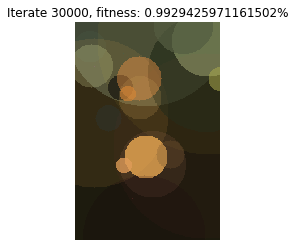

In [45]:
plot_best_phenotype(genotypes_history, fitness_history, (384, 256, 3), 100)

In [197]:
file = f'./Mona-reproduction5/backup-30000.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
background = genotype_to_phenotype(last_genotype, (384, 256, 3))

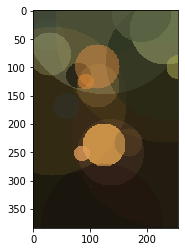

In [198]:
plt.imshow(background)

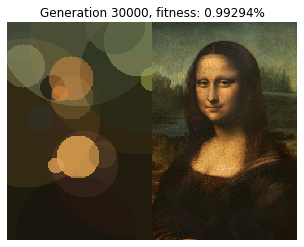

In [199]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, org=mona2_256)

#### Part 2: (circles 26-50, generations 30000-60000)

In [66]:
genotypes_history, fitness_history = GA(30000, 40, 40, 25, mona2_256, (384, 256, 3), elitism=4, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,1000,1),
    elitism_after_adding_circles = True, backups=5000, background=background)

Iteration: 0, best fitness: 0.992976348882429
Iteration: 1000, best fitness: 0.993045199193768
Iteration: 2000, best fitness: 0.9932017708105928
Iteration: 3000, best fitness: 0.9932673431072406
Iteration: 4000, best fitness: 0.9936930359170326
Iteration: 5000, best fitness: 0.9939472317201064
Iteration: 6000, best fitness: 0.9940814111425174
Iteration: 7000, best fitness: 0.9941804805185388
Iteration: 8000, best fitness: 0.9942662359760783
Iteration: 9000, best fitness: 0.994343395828099
Iteration: 10000, best fitness: 0.9943735694097738
Iteration: 11000, best fitness: 0.994486150036921
Iteration: 12000, best fitness: 0.9946126019614857
Iteration: 13000, best fitness: 0.99472934196469
Iteration: 14000, best fitness: 0.9947001104474998
Iteration: 15000, best fitness: 0.9948478253633813
Iteration: 16000, best fitness: 0.9950026148975653
Iteration: 17000, best fitness: 0.9947109359427719
Iteration: 18000, best fitness: 0.9949076673094472
Iteration: 19000, best fitness: 0.9949435756467747

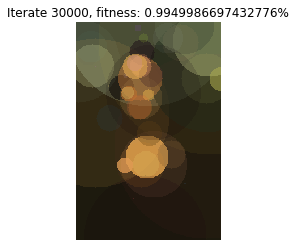

In [68]:
plot_best_phenotype(genotypes_history, fitness_history, (384, 256, 3), 500, background)

In [200]:
file = f'./Mona-reproduction6/backup-30000.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
new_background = genotype_to_phenotype(genotypes_history[-1], (384, 256, 3), background)

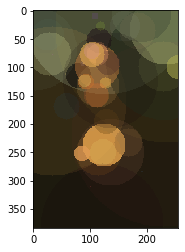

In [201]:
plt.imshow(new_background)

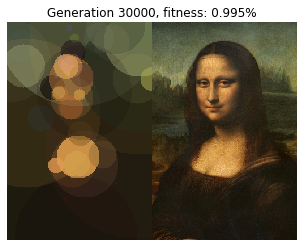

In [202]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, background=background, org=mona2_256)

#### Part 3: (circles 51-75, generations 60000-90000)

In [72]:
genotypes_history, fitness_history = GA(30000, 40, 40, 25, mona2_256, (384, 256, 3), elitism=4, 
    log_every=1000, mutate_prob=0.2, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,1000,1),
    elitism_after_adding_circles = True, backups=5000, background=new_background)

Iteration: 0, best fitness: 0.9949983109758418
Iteration: 1000, best fitness: 0.9950175142682285
Iteration: 2000, best fitness: 0.9951787305669315
Iteration: 3000, best fitness: 0.9952964952055355
Iteration: 4000, best fitness: 0.9953543872074149
Iteration: 5000, best fitness: 0.9953802904530132
Iteration: 6000, best fitness: 0.9953836055328751
Iteration: 7000, best fitness: 0.9954852771189635
Iteration: 8000, best fitness: 0.99555726882294
Iteration: 9000, best fitness: 0.9955911377037565
Iteration: 10000, best fitness: 0.9956359213415729
Iteration: 11000, best fitness: 0.9956395629474217
Iteration: 12000, best fitness: 0.9957183565324524
Iteration: 13000, best fitness: 0.995753629286624
Iteration: 14000, best fitness: 0.9957844437602041
Iteration: 15000, best fitness: 0.9957627539302567
Iteration: 16000, best fitness: 0.9957952348829383
Iteration: 17000, best fitness: 0.9958298994692172
Iteration: 18000, best fitness: 0.9958526244094472
Iteration: 19000, best fitness: 0.9958835602011

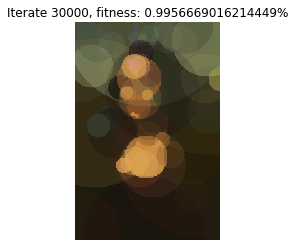

In [73]:
plot_best_phenotype(genotypes_history, fitness_history, (384, 256, 3), 500, new_background)

In [203]:
file = f'./Mona-reproduction7/backup-30000.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
background3 = genotype_to_phenotype(genotypes_history[-1], (384, 256, 3), new_background)

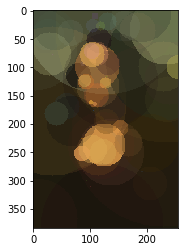

In [204]:
plt.imshow(background3)

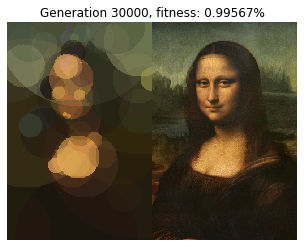

In [205]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, background=new_background, org=mona2_256)

#### Part 4: (circles 76-100, generations 90000-97500)

In [38]:
genotypes_history, fitness_history = GA(7500, 50, 50, 25, mona2_256, (384, 256, 3), elitism=5, 
    log_every=500, mutate_prob=0.25, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,250,1),
    elitism_after_adding_circles = True, backups=2500, background=background3)

Iteration: 0, best fitness: 0.995663693396339
Iteration: 500, best fitness: 0.9957692398477666
Iteration: 1000, best fitness: 0.9958193005261363
Iteration: 1500, best fitness: 0.9958713612506239
Iteration: 2000, best fitness: 0.9958514892112228
Iteration: 2500, best fitness: 0.9959290850025477
Iteration: 3000, best fitness: 0.9959477434279136
Iteration: 3500, best fitness: 0.9959623234986366
Iteration: 4000, best fitness: 0.9960088938585794
Iteration: 4500, best fitness: 0.9960040272903016
Iteration: 5000, best fitness: 0.9959830976230948
Iteration: 5500, best fitness: 0.9960114423744005
Iteration: 6000, best fitness: 0.996011155282613
Iteration: 6500, best fitness: 0.9960360618493298
Iteration: 7000, best fitness: 0.9960607118799872
Iteration: 7500, best fitness: 0.9960763659171861


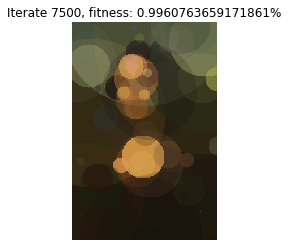

In [40]:
plot_best_phenotype(genotypes_history, fitness_history, (384, 256, 3), 100, new_background)

In [206]:
file = f'./Mona-reproduction8/backup-7500.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
background4 = genotype_to_phenotype(genotypes_history[-1], (384, 256, 3), background3)

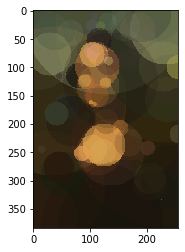

In [207]:
plt.imshow(background4)

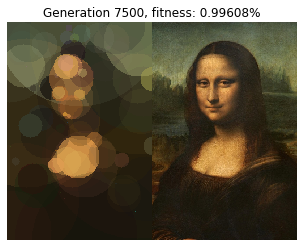

In [208]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, background=background3, org=mona2_256)

In [55]:
files = [f'./Mona-reproduction5/backup-30000.npy', 
         f'./Mona-reproduction6/backup-30000.npy', 
         f'./Mona-reproduction7/backup-30000.npy',
         f'./Mona-reproduction8/backup-7500.npy']
actual_genotype = np.array([0,0,0,0,0,0,0])
for file in files:
    genotypes_history = np.load(file, allow_pickle=True)
    last_genotype = genotypes_history[-1]
    actual_genotype = np.vstack([actual_genotype, last_genotype])
actual_genotype = actual_genotype[1:]

In [59]:
backgound = genotype_to_phenotype(actual_genotype, (384, 256, 3))

#### Part 5: (circles 100-120, generations 97500-107500)

In [62]:
genotypes_history, fitness_history = GA(15000, 50, 50, 25, mona2_256, (384, 256, 3), elitism=5, 
    log_every=500, mutate_prob=0.25, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,500,1),
    elitism_after_adding_circles = True, backups=2500, background=backgound)

Iteration: 0, best fitness: 0.9960757271824845
Iteration: 500, best fitness: 0.9960998231475579
Iteration: 1000, best fitness: 0.9961171953757704
Iteration: 1500, best fitness: 0.99617886111579
Iteration: 2000, best fitness: 0.9961792121909792
Iteration: 2500, best fitness: 0.9961949552626566
Iteration: 3000, best fitness: 0.9962280078167516
Iteration: 3500, best fitness: 0.9962001430608346
Iteration: 4000, best fitness: 0.9962624616083823
Iteration: 4500, best fitness: 0.9962136862698093
Iteration: 5000, best fitness: 0.996247928703466
Iteration: 5500, best fitness: 0.9962777090354996
Iteration: 6000, best fitness: 0.9963359208813081
Iteration: 6500, best fitness: 0.9963501722265726
Iteration: 7000, best fitness: 0.996256587027512
Iteration: 7500, best fitness: 0.99630803625873
Iteration: 8000, best fitness: 0.9963190617808088
Iteration: 8500, best fitness: 0.9962341796027387
Iteration: 9000, best fitness: 0.9962826885679262
Iteration: 9500, best fitness: 0.996314161387273
Iteration: 

KeyboardInterrupt: 

In [209]:
file = f'./Mona-reproduction9/backup-10000.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
background5 = genotype_to_phenotype(genotypes_history[-1], (384, 256, 3), background4)

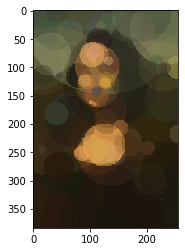

In [210]:
plt.imshow(background5)

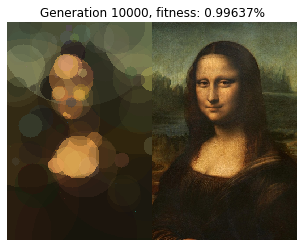

In [211]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, background=background4, org=mona2_256)

In [64]:
files = [f'./Mona-reproduction5/backup-30000.npy', 
         f'./Mona-reproduction6/backup-30000.npy', 
         f'./Mona-reproduction7/backup-30000.npy',
         f'./Mona-reproduction8/backup-7500.npy',
        f'./Mona-reproduction9/backup-10000.npy']
actual_genotype = np.array([0,0,0,0,0,0,0])
for file in files:
    genotypes_history = np.load(file, allow_pickle=True)
    last_genotype = genotypes_history[-1]
    actual_genotype = np.vstack([actual_genotype, last_genotype])
actual_genotype = actual_genotype[1:]

In [65]:
backgound = genotype_to_phenotype(actual_genotype, (384, 256, 3))

#### Part 6: (circles 120-140, generations 107500-120000)

In [68]:
genotypes_history, fitness_history = GA(12500, 50, 50, 20, mona2_256, (384, 256, 3), elitism=5, 
    log_every=500, mutate_prob=0.25, mutation=muatate_with_shuffle, 
    current_number_of_circles=lambda a,b,c:stepping_number_of_circles(a,b,c,500,1),
    elitism_after_adding_circles = True, backups=2500, background=backgound)

Iteration: 0, best fitness: 0.9963718813552638
Iteration: 500, best fitness: 0.9964065670200806
Iteration: 1000, best fitness: 0.996438809547653
Iteration: 1500, best fitness: 0.9964609766314854
Iteration: 2000, best fitness: 0.9965243869630882
Iteration: 2500, best fitness: 0.9965310536414705
Iteration: 3000, best fitness: 0.9965560436545414
Iteration: 3500, best fitness: 0.9965955390589476
Iteration: 4000, best fitness: 0.9965865030877964
Iteration: 4500, best fitness: 0.9966136239532143
Iteration: 5000, best fitness: 0.9965909783680174
Iteration: 5500, best fitness: 0.9966113686377974
Iteration: 6000, best fitness: 0.9965411239353694
Iteration: 6500, best fitness: 0.996574604736766
Iteration: 7000, best fitness: 0.9965513255759766
Iteration: 7500, best fitness: 0.9965197120728626
Iteration: 8000, best fitness: 0.9965515450475342
Iteration: 8500, best fitness: 0.99652280524531
Iteration: 9000, best fitness: 0.9965349994445029
Iteration: 9500, best fitness: 0.9965513753475874
Iteratio

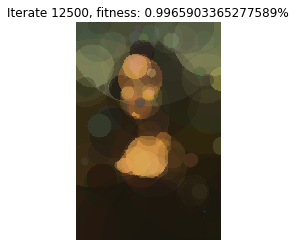

In [70]:
plot_best_phenotype(genotypes_history, fitness_history, (384, 256, 3), 100, backgound)

In [212]:
file = f'./Mona-reproduction10/backup-12500.npy'
genotypes_history = np.load(file, allow_pickle=True)
last_genotype = genotypes_history[-1]
background6 = genotype_to_phenotype(genotypes_history[-1], (384, 256, 3), background5)

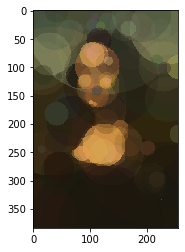

In [213]:
plt.imshow(background6)

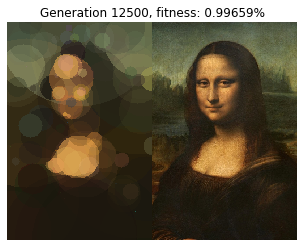

In [214]:
plot_best_phenotype(genotypes_history, None, (384, 256, 3), 500, background=background5, org=mona2_256)

### WCSS results

In [12]:
bg1_genotype = np.load('./WCSS/current_genotype.npy', allow_pickle=True)

In [13]:
bg1 = genotype_to_phenotype(bg1_genotype, (384, 256, 3))

0.9965903365277589

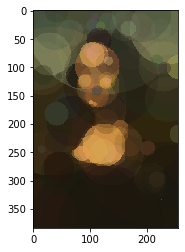

In [31]:
plt.imshow(bg1)
MAX_ERROR = np.square((1 - (mona2_256 >= 0.5)) * 1.0 - mona2_256).mean(axis=None)
MSE_fintess(np.array([bg1]), MAX_ERROR, mona2_256)[0]

In [20]:
short_training_results = np.load('./WCSS/output-run1.npy', allow_pickle=True)[1:]
full_training_results = np.load('./WCSS/output-run2.npy', allow_pickle=True)[1:]

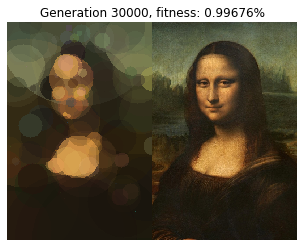

In [32]:
plot_best_phenotype(full_training_results, None, (384, 256, 3), 100, org=mona2_256, background=bg1)

In [41]:
current_genotype = np.vstack((bg1_genotype,full_training_results[-1]))

In [42]:
#np.save('./Evo-project/current_genotype2', current_genotype)

----------------

In [30]:
bg2_genotype = np.load('./WCSS/current_genotype2.npy', allow_pickle=True)

In [32]:
bg2 = genotype_to_phenotype(bg2_genotype, (384, 256, 3))

0.9967636963920904

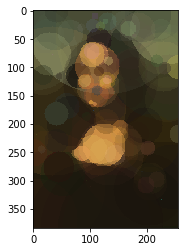

In [33]:
plt.imshow(bg2)
MAX_ERROR = np.square((1 - (mona2_256 >= 0.5)) * 1.0 - mona2_256).mean(axis=None)
MSE_fintess(np.array([bg2]), MAX_ERROR, mona2_256)[0]

In [34]:
full_training_results_2 = np.load('./WCSS/output-run3.npy', allow_pickle=True)[1:]

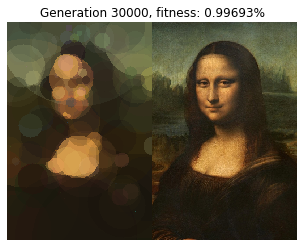

In [35]:
plot_best_phenotype(full_training_results_2, None, (384, 256, 3), 500, org=mona2_256, background=bg2)

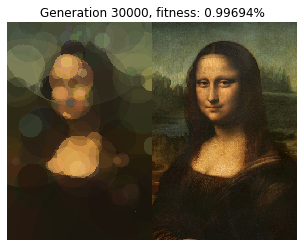

In [36]:
full_training_results_3 = np.load('./WCSS/output-run4.npy', allow_pickle=True)[1:]
plot_best_phenotype(full_training_results_3, None, (384, 256, 3), 500, org=mona2_256, background=bg2)

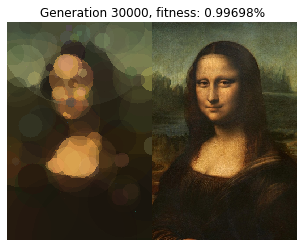

In [37]:
full_training_results_4 = np.load('./WCSS/output-run5.npy', allow_pickle=True)[1:]
plot_best_phenotype(full_training_results_4, None, (384, 256, 3), 500, org=mona2_256, background=bg2)

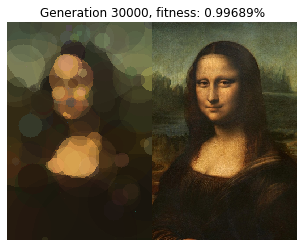

In [38]:
full_training_results_5 = np.load('./WCSS/output-run6.npy', allow_pickle=True)[1:]
plot_best_phenotype(full_training_results_5, None, (384, 256, 3), 500, org=mona2_256, background=bg2)

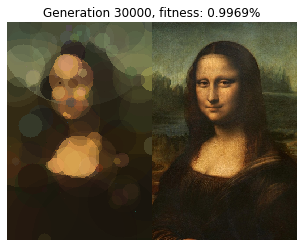

In [39]:
full_training_results_6 = np.load('./WCSS/output-run7.npy', allow_pickle=True)[1:]
plot_best_phenotype(full_training_results_6, None, (384, 256, 3), 500, org=mona2_256, background=bg2)

### Saving the final results

In [40]:
files = ['./Mona-reproduction5/backup-30000.npy', 
        './Mona-reproduction6/backup-30000.npy', 
        './Mona-reproduction7/backup-30000.npy',
        './Mona-reproduction8/backup-7500.npy',
        './Mona-reproduction9/backup-10000.npy',
        './Mona-reproduction10/backup-12500.npy',
        './WCSS/output-run2.npy',
        './WCSS/output-run5.npy'
        ]
genotypes_history = np.load(files[0], allow_pickle=True)[1:]
final_genotype = genotypes_history[-1]
final_genotype_history = genotypes_history[:-1]
for file in files[1:-1]:
    genotypes_history = np.load(file, allow_pickle=True)[1:]
    last_genotype = genotypes_history[-1]
    genotypes_history = np.array([np.vstack([final_genotype, h]) for h in genotypes_history[:-1]])
    final_genotype = np.vstack([final_genotype, last_genotype])
    final_genotype_history = np.hstack([final_genotype_history,genotypes_history])
genotypes_history = np.load(files[-1], allow_pickle=True)[1:]
last_genotype = genotypes_history[-1]
genotypes_history = np.array([np.vstack([final_genotype, h]) for h in genotypes_history])
final_genotype = np.vstack([final_genotype, last_genotype])
final_genotype_history = np.hstack([final_genotype_history,genotypes_history])

In [41]:
lens = ([1000]*24+[6000])*3+[250]*24+[1500]+[500]*39+[3000]+[1000]*24+[6000]+[1000]*24+[6001]
circles_history_ = [[i]*lens[i-1] for i in range(1,len(lens)+1)]
circles_history = []
for e in circles_history_:
    circles_history = circles_history + e
circles_history = np.array(circles_history)

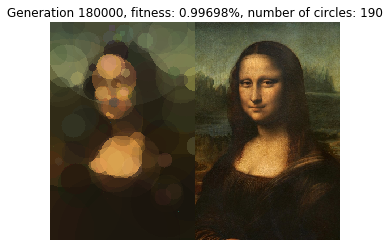

In [42]:
plot_best_phenotype(final_genotype_history, None, (384, 256, 3), 1000, org=mona2_256, circles_history=circles_history)

In [43]:
np.save(f'final_genotype', final_genotype)
np.save(f'final_genotype_history', final_genotype_history)